## load cmip6 data, use previously calculated timing of when each climate model crosses global warming thresholds  to calculate local impacts (in precipitation in this case) at these thresholds

In [1]:
%matplotlib inline
import xarray as xr
import pandas as pd
import numpy as np
from scipy import stats
from scipy import signal
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import intake
import fsspec # for loading data from s3
import warnings
warnings.filterwarnings("ignore")

## load df of list of models, warming threshold timing

In [2]:
df = pd.read_csv('CMIP6_nModels_35_GWLevels_ssp585_Smoothed_FirstYearThreshold.csv')

#create a list of model names from the first column of CMIP6 Models listed
name_list = df['CMIP6 Model'].tolist()

#look at the loaded dataframe
df

,CMIP6 Model,1.0,1.5,2.0,2.5,3.0
0,ACCESS-CM2,2015,2026,2039,2049,2056
1,ACCESS-ESM1-5,2014,2028,2040,2051,2061
2,AWI-CM-1-1-MR,2003,2020,2037,2050,2060
3,BCC-CSM2-MR,2018,2031,2044,2055,2066
4,CAMS-CSM1-0,2023,2045,2060,2075,2088
5,CAS-ESM2-0,2019,2034,2045,2053,2062
6,CESM2-WACCM,2007,2021,2034,2045,2054
7,CIESM,1996,2016,2030,2042,2050
8,CMCC-CM2-SR5,2003,2022,2034,2044,2053
9,CMCC-ESM2,2004,2030,2040,2048,2056


In [3]:
# Define where catalog is
catalog_url = "https://cmip6-pds.s3.amazonaws.com/pangeo-cmip6.json"  # CMIP6 catalog URL on AWS
col = intake.open_esm_datastore(catalog_url)  # Open the CMIP6 catalog using Intake-ESM

ssp = 'ssp585'

variable = 'pr'

# Define our query
query = dict(
variable_id=[variable], #load precipitation data!
experiment_id=["historical", ssp],
table_id=["Amon"],
member_id = ["r1i1p1f1"],
source_id = name_list) #load the climate model data listed from the df from the csv file above

col_subset = col.search(**query)  # Search and filter the catalog based on the query

# Group and display relevant columns to inspect results
col_subset.df.groupby("source_id")[["experiment_id", "variable_id", "table_id"]]

col_subset = col_subset.search(require_all_on=["source_id"], **query)  # Further refine the search to ensure all criteria match
col_subset.df.groupby("source_id")[["experiment_id", "variable_id", "table_id"]]  # Re-check the filtered results

# Filter to only include historical data for the "tas" variable
col_subset_historical = col_subset.search(variable_id=[variable], experiment_id=["historical"])
col_subset_historical.df.sort_values("source_id")  # Sort the results by source_id

col_subset_ssp = col_subset.search(variable_id=[variable],experiment_id=[ssp])
col_subset_ssp.df.sort_values("source_id")

#define anonymous access
storage_options = {"anon": True}

datasets_historical = col_subset_historical.to_dataset_dict(cdf_kwargs={},storage_options=storage_options)  # Convert the filtered results into xarray datasets
datasets_ssp = col_subset_ssp.to_dataset_dict(cdf_kwargs={},storage_options=storage_options)

#uncomment next line to display the dataframe
#col_subset_historical.df



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


## loop through and load each model and save impacts

In [4]:
%%time 
#time how long it takes to loop through all CMIP6 models defined above

#define min/max lat and lon for region of interest
lat_min = -15
lat_max = 0
lon_min = 360 - 60
lon_max = 360 - 50

#empty list to be filled with each model name
cmip6_models = []

for hii, hi in enumerate(datasets_historical):  # Loop through historical datasets, hii is the index, hi is the dataset key
    
    ds_historical = datasets_historical[hi]  # Get the historical dataset for the current model
    
    for sii, si in enumerate(datasets_ssp):  # Nested loop through ssp datasets, sii is the index, si is the dataset key
        
        ds_ssp = datasets_ssp[si]  # Get the ssp dataset for the current model
        
        if ds_ssp.attrs['source_id'] == ds_historical.attrs['source_id']:  # Match datasets by model (source_id)
            
            print('loading data for both experiments from:', ds_ssp.attrs['source_id'])  # Inform which model is being processed

            #append this model's name to list
            cmip6_models.append(ds_ssp.attrs['source_id'])
            
            if variable == 'tas':
                
                da_historical = (ds_historical[str(variable)] -273.15).compute() # Convert historical 'tas' (temperature) from Kelvin to Celsius
                
            if variable == 'pr':
                
                da_historical = (ds_historical[str(variable)] * 3600 * 24).compute() #convert from kg/m2/sec to mm/day
            
            # Calculate the seasonal mean temperature for historical data (1850-2014)
            da_historical_ann = da_historical.sel(time=da_historical.time.dt.month.isin([6,7,8])).groupby('time.year').mean("time").sel(year=slice(1850, 2014))
            
            if variable == 'tas':
                print('variable is',variable,'so converting from K to C')
                da_ssp = (ds_ssp[str(variable)] - 273.15).compute() # Convert 'tas' (temperature) from Kelvin to Celsius
                
            if variable == 'pr':
                print('variable is',variable,'so converting from kg/m2/sec to mm/day')
                da_ssp = (ds_ssp[str(variable)] * 3600 * 24).compute() #convert from kg/m2/sec to mm/day
                      
            # Calculate the seasonal mean temperature for ssp data (2015-2100)
            da_ssp_ann = da_ssp.sel(time=da_ssp.time.dt.month.isin([6,7,8])).groupby('time.year').mean("time").sel(year=slice(2015, 2100))

            # Concatenate the historical and ssp data along the 'year' dimension
            da_historical_ssp_ann = xr.concat((da_historical_ann, da_ssp_ann), dim='year')
            
            #slide out a specific region of interest for creating area-weighted average
            da_historical_ssp_ann = da_historical_ssp_ann.sel(lat=slice(lat_min,lat_max),lon=slice(lon_min,lon_max))
            
            # Calculate weights based on latitude for global mean (cosine latitude weighting)
            w = np.cos(np.deg2rad(da_historical_ssp_ann.lat))
            w = w.broadcast_like(da_historical_ssp_ann)  # Ensure weights have the same shape as the data
            
            # Calculate global mean temperature using area weights (latitude weighted average)
            area_mean = ((w * da_historical_ssp_ann).sum(dim=('lon', 'lat')) / w.sum(dim=('lon', 'lat'))).compute()
            
            if hii == 0:  # For the first iteration, initialize the global mean temperature (gmt) collection
                cmip6_area_mean = area_mean
            else:
                # For subsequent iterations, concatenate the global mean temperature data along the 'model' dimension
                cmip6_area_mean = xr.concat((cmip6_area_mean, area_mean), dim='model')


loading data for both experiments from: EC-Earth3-Veg-LR
variable is pr so converting from kg/m2/sec to mm/day
loading data for both experiments from: GFDL-ESM4
variable is pr so converting from kg/m2/sec to mm/day
loading data for both experiments from: NorESM2-MM
variable is pr so converting from kg/m2/sec to mm/day
loading data for both experiments from: CAMS-CSM1-0
variable is pr so converting from kg/m2/sec to mm/day
loading data for both experiments from: CMCC-CM2-SR5
variable is pr so converting from kg/m2/sec to mm/day
loading data for both experiments from: EC-Earth3-Veg
variable is pr so converting from kg/m2/sec to mm/day
loading data for both experiments from: CAS-ESM2-0
variable is pr so converting from kg/m2/sec to mm/day
loading data for both experiments from: FGOALS-f3-L
variable is pr so converting from kg/m2/sec to mm/day
loading data for both experiments from: ACCESS-CM2
variable is pr so converting from kg/m2/sec to mm/day
loading data for both experiments from: AWI

In [5]:
sorting_indices = np.argsort(cmip6_models)
print('sorting indices are: ',sorting_indices)
cmip6_models_sorted = np.array(cmip6_models)[sorting_indices]

#sort data by model name
cmip6_area_mean_sorted = cmip6_area_mean[sorting_indices,0,0,:]
#cmip6_area_mean_sorted

# calculate changed in local variable of interest from the pre-industrial
cmip6_area_mean_sorted_anomalies = cmip6_area_mean_sorted - cmip6_area_mean_sorted.sel(year=slice(1850,1899)).mean(dim='year')

sorting indices are:  [ 8 11  9 22  3  6 16  4 23 19 30 32 18  5  0  7 14 27 31  1 12 20 15 28
 17 21 26 13 24 10 25  2 29]


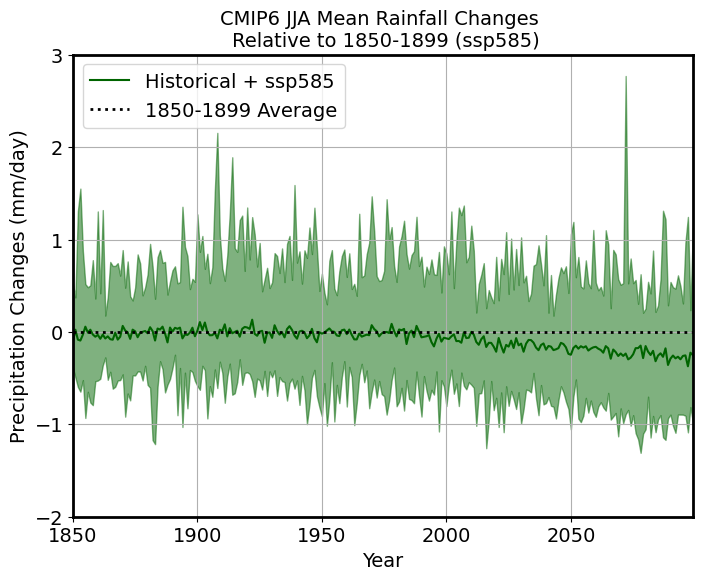

In [7]:
time = cmip6_area_mean_sorted_anomalies.year

fsize = 14

fig = plt.figure(figsize=(8,6)) #set figure size

ax = plt.subplot(1,1,1)

plt.fill_between(time,
                 cmip6_area_mean_sorted_anomalies.max(dim='model'),
                 cmip6_area_mean_sorted_anomalies.min(dim='model'),
                 color='darkgreen',
                alpha=0.5)
plt.plot(time,
         cmip6_area_mean_sorted_anomalies.median(dim='model'),
         color='darkgreen',
        label='Historical + '+str(ssp))


plt.xlim(1850,2099)
plt.ylim(-2,3)
plt.grid()
plt.axhline(0, color='black', linestyle=':',linewidth=2,label=('1850-1899 Average'))
plt.xticks(fontsize=fsize)
plt.yticks(fontsize=fsize)
plt.xlabel('Year',fontsize=fsize)
plt.ylabel('Precipitation Changes (mm/day)',fontsize=fsize)
plt.legend(loc='upper left',fontsize=fsize)
plt.title('CMIP6 JJA Mean Rainfall Changes \n Relative to 1850-1899 ('+str(ssp)+')',fontsize=fsize)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)


## the time series is a fine way of looking at warming impacts, but it's dependent on timing/magnitude of future emissions
## let's try looking at impacts at warming levels instead

In [8]:
temps = df.columns[1:]

for mi,model in enumerate(cmip6_models_sorted): # all but TaiESM bc weird nonsensical jump in data!
    #pick out on model
    da = cmip6_area_mean_sorted_anomalies[mi,:]
    
    for ti,temp in enumerate(temps):
        
        #select year when this temperature/warming level reached 
        yr = int(df[df['CMIP6 Model'] == model][str(temp)].item())   

        #average 20 years around this warming level
        da_slice = da.sel(year=slice(yr-9,yr+10)).mean(dim='year')
        da_slice = da_slice.assign_coords(gwl=temp)

        if ti == 0:
            da_slice_all_gwls = da_slice
        else:
            da_slice_all_gwls = xr.concat((da_slice_all_gwls,da_slice),dim='gwl')
            
    if  mi == 0:
        da_slice_all_gwls_allmodels = da_slice_all_gwls
    else:
        da_slice_all_gwls_allmodels = xr.concat((da_slice_all_gwls_allmodels,da_slice_all_gwls),dim='model')
       

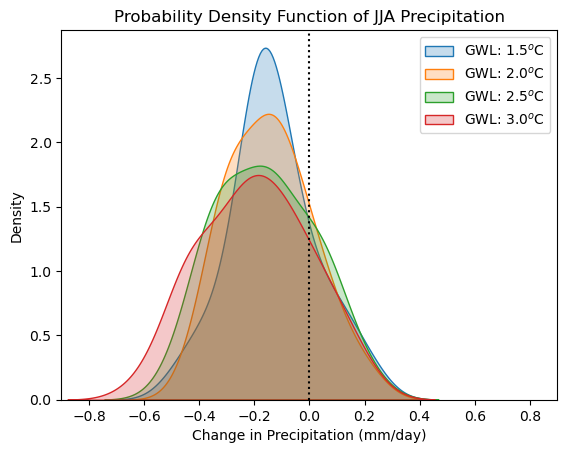

In [9]:
# Plot the PDF using seaborn
for ti,temp in enumerate(temps[1:]):
    sns.kdeplot(da_slice_all_gwls_allmodels[:,ti+1], fill=True,label='GWL: '+str(temp)+'$^o$C')
plt.title('Probability Density Function of JJA Precipitation')
plt.xlabel('Change in Precipitation (mm/day)')
plt.xlim([-0.9,0.9])
plt.axvline(x = 0, color = 'k', linestyle=':')
plt.ylabel('Density')
plt.legend()
plt.show()